# Climate and vegetation

- Variables are: `NDVI_ano`, `SWVL1_ano`, `STL1_ano`, `WB_ano`, `WD_ano`, `TP_ano`, `E_ano`, `RELHUM_ano`, `SSR_ano`, and `T2M_ano`.
- `Spearman rank correlation` between vegetation and climate variables with and without lags.
- Lags are 1, 2, 3, and 6.
- Local analysis for Manaus.
    - Plot time series.
    - Autocorrelation.
    - Pair plots.

## 1 Initial setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load packages.
import sys
import glob

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from cartopy import crs as ccrs
from cartopy import feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid

%matplotlib inline

In [4]:
# First we will use cartopy's shapereader to download (and cache) 
# states shapefile with 50 meters resolution from the NaturalEarth.
kw = dict(
    resolution="50m", 
    category="cultural", 
    name="admin_1_states_provinces"
)
states_shp = shapereader.natural_earth(**kw)
shp = shapereader.Reader(states_shp)

In [5]:
print(">>> Version of xarray:", xr.__version__)

>>> Version of xarray: 0.14.0


In [7]:
# My repository.
repository = "/home/alex/Dropbox/repositories/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package.
import cdlearn
from cdlearn.auxiliary import dict_units, dict_titles_pt

# Map borders.
loni, lonf, lati, latf = -90, -30, -60, 20

# Time range. The same as GIMMS ndvi.
ti, tf = "1981-07", "2015-12"

# Where figures will be put.
fig_path = "/home/alex/Dropbox/repositories/phd/images/"

## 2 Load monthly anomaly data

**Command for deleting index files:**

```bash
>>> find /media/alex/ALEXDATA/data_sets/ERA_INTERIM/ -name "*.idx" -type f -delete
```

In [8]:
%%time

# Monthly means (mm).
var_labels = [
    "NDVI_ano", 
    "SWVL1_ano", 
    "STL1_ano", 
    "WB_ano",
    "WD_ano",
    "TP_ano", 
    "E_ano", 
    "RELHUM_ano", 
    "SSR_ano", 
    "T2M_ano"
]

codes = [
    "ndvi", 
    "swvl1", 
    "stl1", 
    "wb",
    "wd",
    "tp", 
    "e", 
    "relhum", 
    "ssr", 
    "t2m"
]

# South America.
region = {
    "loni": loni, 
    "lonf": lonf, 
    "lati": lati, 
    "latf": latf
}

# The same as GIMMS ndvi.
time_range = {
    "ti": ti, 
    "tf": tf
}

verbose = False
cd = cdlearn.pixels.ClimateData(
    var_labels=var_labels, 
    region=region,
    time_range=time_range,
    verbose=verbose
)

CPU times: user 9.09 s, sys: 254 ms, total: 9.34 s
Wall time: 21 s


**DANGER ZONE! Memory intensive operation**

In [9]:
%%time

DSs = cd.load_into_memory(verbose=verbose)

CPU times: user 8.79 s, sys: 2.71 s, total: 11.5 s
Wall time: 57 s


## 3 Nonlinear correlations between variables (monthly data)

In [10]:
%%time

# Correlations between vegetation and climate anomalies.
rhos = []
for index, var_label in enumerate(var_labels):
    
    if index > 0: 
    
        # Select variables.
        da1 = DSs["NDVI_ano"].ano  # Always ndvi.  
        da2 = DSs[var_label].ano
        
        # Linear relationship.
        rho = cdlearn.statistics.correlation(da1, da2, lag=0, method="spearman")

        # Put mask.
        rho = cdlearn.pixels.EraInterimGrid.add_land_mask(rho)
    
        # Add to list of results.
        rhos.append(rho)

CPU times: user 58.9 s, sys: 202 ms, total: 59.1 s
Wall time: 57.8 s


CPU times: user 6.08 s, sys: 99.3 ms, total: 6.17 s
Wall time: 6.37 s


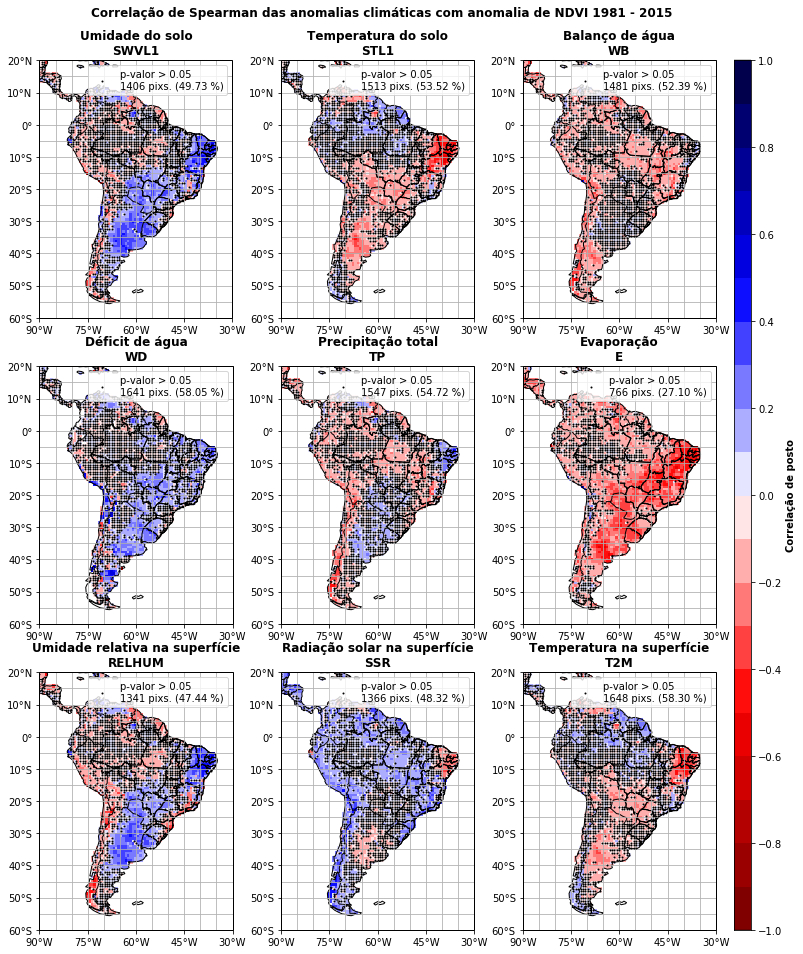

In [11]:
%%time

titles = [
    "Umidade do solo\n" + codes[1].upper(),
    "Temperatura do solo\n" + codes[2].upper(),
    "Balanço de água\n" + codes[3].upper(),
    "Déficit de água\n" + codes[4].upper(),
    "Precipitação total\n" + codes[5].upper(),
    "Evaporação\n" + codes[6].upper(),
    "Umidade relativa na superfície\n" + codes[7].upper(),
    "Radiação solar na superfície\n" + codes[8].upper(),
    "Temperatura na superfície\n" + codes[9].upper()
]

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 15))

axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 3),
    axes_pad=0.675,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = rhos[index].sel(stats="rho").where(rhos[index].land_mask == True).plot(
        ax=axis,
        vmin=-1.0,
        vmax=1.0,
        levels=np.arange(-1.0, 1.1, 0.1),
        cmap=plt.cm.seismic_r,
        add_colorbar=False,
        add_labels=False
    )

    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )    

    # Statistical significant trends.
    mask = rhos[index].sel(stats="p_value").where(rhos[index].land_mask == True) > 0.05
    LON, LAT = np.meshgrid(mask.longitude.values, mask.latitude.values)

    # Insignificant linear relations.
    only_land = (~mask.where(mask.land_mask==True).isnull()).sum().values
    axis.plot(LON[mask], LAT[mask], ".k", markersize=2, 
              label="p-valor > 0.05\n" + str(mask.sum().values) + " pixs. " + \
                    str("(%.2f %%)" %(mask.sum().values / only_land * 100)), 
              transform=projection)
    # Legend.    
    axis.legend(loc=1)     
        
# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Correlação de posto", weight="bold")
cb.cbar_axis.set_ticks(np.arange(-1.0, 1.2, 0.2))        
plt.suptitle("Correlação de Spearman das anomalias climáticas com anomalia de NDVI" + \
             " 1981 - 2015", weight="bold")
plt.subplots_adjust(top=0.93)    

# Save figures.
plt.savefig(fig_path + "ndvi_climate_spearman_ano_pt.jpg", dpi=200, bbox_inches="tight")

In [11]:
%%time

# Correlations between vegetation and climate anomalies.
rhos = []
for index, var_label in enumerate(var_labels):
    
    if index > 0: 
    
        # Select variables.
        da1 = DSs["NDVI_ano"].ano  # Always ndvi.  
        da2 = DSs[var_label].ano
        
        # Linear relationship.
        rho = cdlearn.statistics.correlation(da1, da2, lag=1, method="spearman")

        # Put mask.
        rho = cdlearn.pixels.EraInterimGrid.add_land_mask(rho)
    
        # Add to list of results.
        rhos.append(rho)

CPU times: user 1min 3s, sys: 284 ms, total: 1min 4s
Wall time: 1min 2s


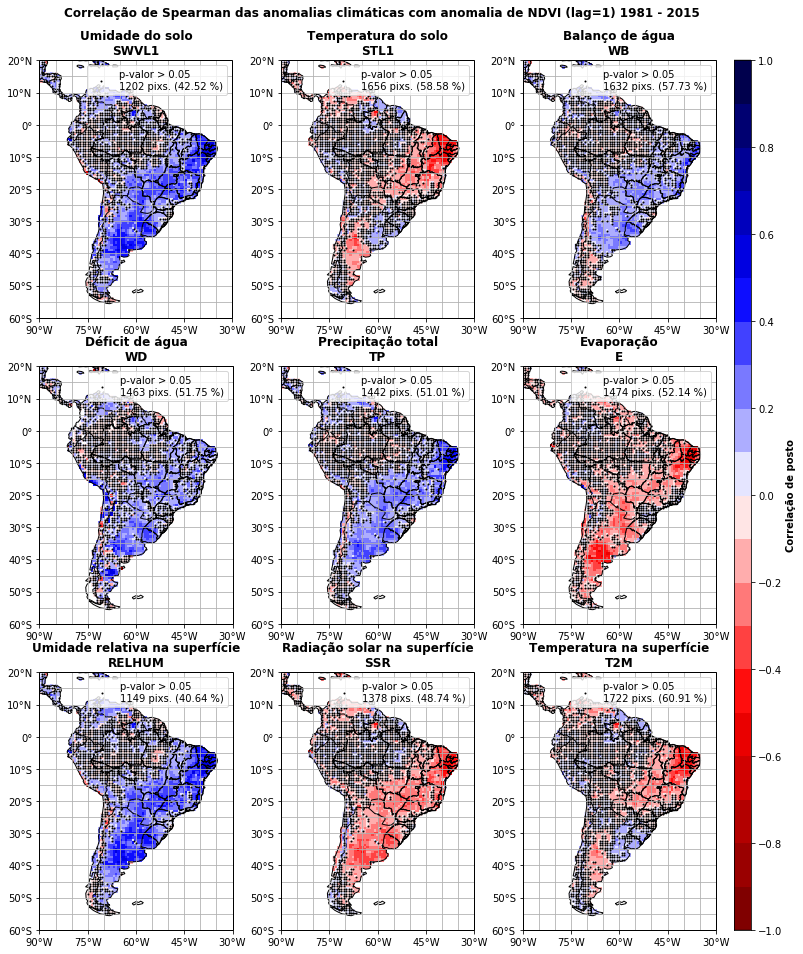

In [12]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 15))

axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 3),
    axes_pad=0.675,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = rhos[index].sel(stats="rho").where(rhos[index].land_mask == True).plot(
        ax=axis,
        vmin=-1.0,
        vmax=1.0,
        levels=np.arange(-1.0, 1.1, 0.1),
        cmap=plt.cm.seismic_r,
        add_colorbar=False,
        add_labels=False
    )

    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )    

    # Statistical significant trends.
    mask = rhos[index].sel(stats="p_value").where(rhos[index].land_mask == True) > 0.05
    LON, LAT = np.meshgrid(mask.longitude.values, mask.latitude.values)

    # Insignificant linear relations.
    only_land = (~mask.where(mask.land_mask==True).isnull()).sum().values
    axis.plot(LON[mask], LAT[mask], ".k", markersize=2, 
              label="p-valor > 0.05\n" + str(mask.sum().values) + " pixs. " + \
                    str("(%.2f %%)" %(mask.sum().values / only_land * 100)), 
              transform=projection)
    # Legend.    
    axis.legend(loc=1)     
        
# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Correlação de posto", weight="bold")
cb.cbar_axis.set_ticks(np.arange(-1.0, 1.2, 0.2))        
plt.suptitle("Correlação de Spearman das anomalias climáticas com anomalia de NDVI (lag=1)" + \
             " 1981 - 2015", weight="bold")
plt.subplots_adjust(top=0.93)    
  

# Save figures.
plt.savefig(fig_path + "ndvi_climate_spearman_lag1_ano_pt.jpg", dpi=200, bbox_inches="tight")

In [13]:
%%time

# Correlations between vegetation and climate anomalies.
rhos = []
for index, var_label in enumerate(var_labels):
    
    if index > 0: 
    
        # Select variables.
        da1 = DSs["NDVI_ano"].ano  # Always ndvi.  
        da2 = DSs[var_label].ano
        
        # Linear relationship.
        rho = cdlearn.statistics.correlation(da1, da2, lag=2, method="spearman")

        # Put mask.
        rho = cdlearn.pixels.EraInterimGrid.add_land_mask(rho)
    
        # Add to list of results.
        rhos.append(rho)

CPU times: user 1min 1s, sys: 279 ms, total: 1min 1s
Wall time: 60 s


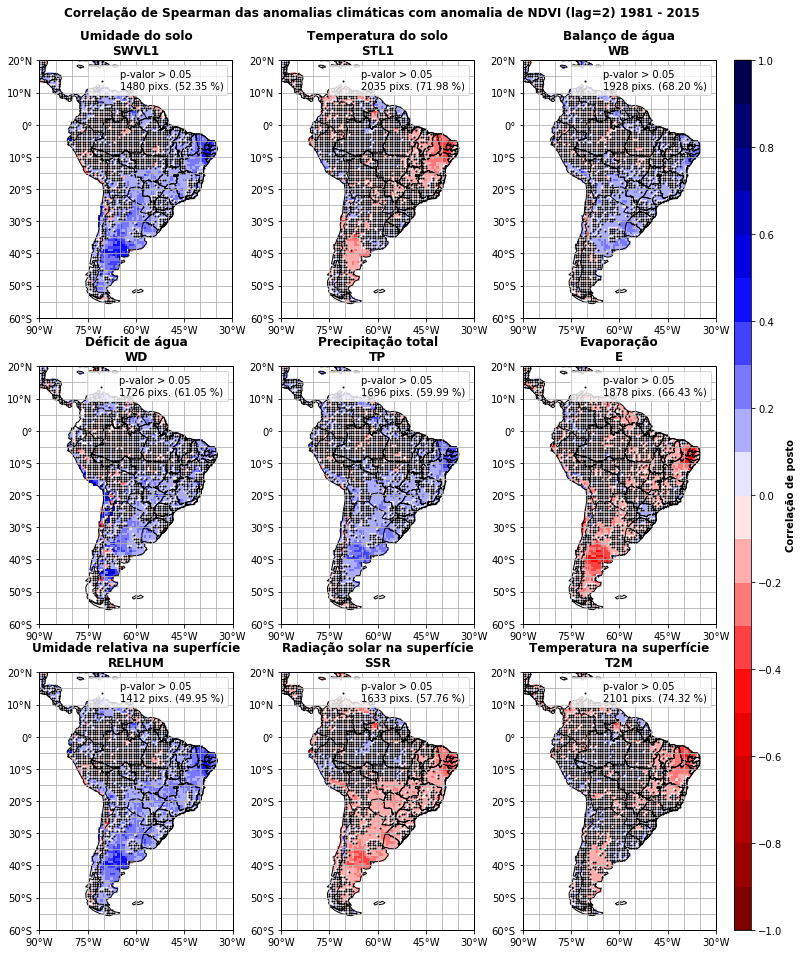

In [14]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 15))

axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 3),
    axes_pad=0.675,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = rhos[index].sel(stats="rho").where(rhos[index].land_mask == True).plot(
        ax=axis,
        vmin=-1.0,
        vmax=1.0,
        levels=np.arange(-1.0, 1.1, 0.1),
        cmap=plt.cm.seismic_r,
        add_colorbar=False,
        add_labels=False
    )

    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )    

    # Statistical significant trends.
    mask = rhos[index].sel(stats="p_value").where(rhos[index].land_mask == True) > 0.05
    LON, LAT = np.meshgrid(mask.longitude.values, mask.latitude.values)

    # Insignificant linear relations.
    only_land = (~mask.where(mask.land_mask==True).isnull()).sum().values
    axis.plot(LON[mask], LAT[mask], ".k", markersize=2, 
              label="p-valor > 0.05\n" + str(mask.sum().values) + " pixs. " + \
                    str("(%.2f %%)" %(mask.sum().values / only_land * 100)), 
              transform=projection)
    # Legend.    
    axis.legend(loc=1)     
        
# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Correlação de posto", weight="bold")
cb.cbar_axis.set_ticks(np.arange(-1.0, 1.2, 0.2))        
plt.suptitle("Correlação de Spearman das anomalias climáticas com anomalia de NDVI (lag=2)" + \
             " 1981 - 2015", weight="bold")
plt.subplots_adjust(top=0.93)    
  

# Save figures.
plt.savefig(fig_path + "ndvi_climate_spearman_lag2_ano_pt.jpg", dpi=200, bbox_inches="tight")

In [15]:
%%time

# Correlations between vegetation and climate anomalies.
rhos = []
for index, var_label in enumerate(var_labels):
    
    if index > 0: 
    
        # Select variables.
        da1 = DSs["NDVI_ano"].ano  # Always ndvi.  
        da2 = DSs[var_label].ano
        
        # Linear relationship.
        rho = cdlearn.statistics.correlation(da1, da2, lag=3, method="spearman")

        # Put mask.
        rho = cdlearn.pixels.EraInterimGrid.add_land_mask(rho)
    
        # Add to list of results.
        rhos.append(rho)

CPU times: user 1min 17s, sys: 454 ms, total: 1min 18s
Wall time: 1min 17s


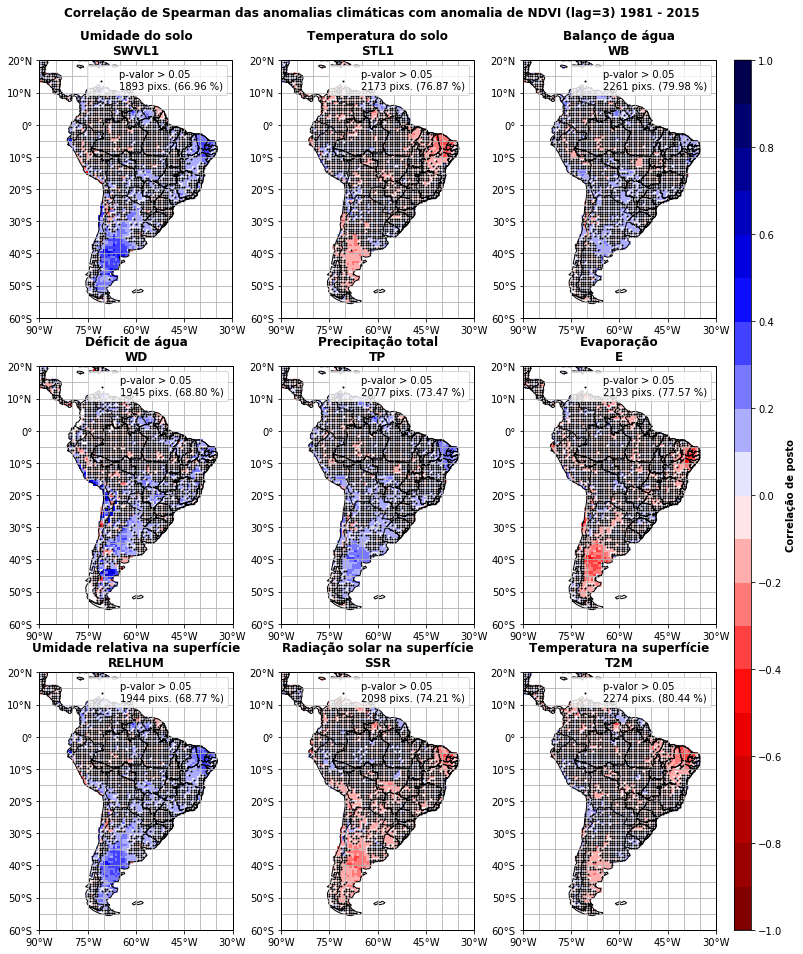

In [16]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 15))

axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 3),
    axes_pad=0.675,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = rhos[index].sel(stats="rho").where(rhos[index].land_mask == True).plot(
        ax=axis,
        vmin=-1.0,
        vmax=1.0,
        levels=np.arange(-1.0, 1.1, 0.1),
        cmap=plt.cm.seismic_r,
        add_colorbar=False,
        add_labels=False
    )

    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )    

    # Statistical significant trends.
    mask = rhos[index].sel(stats="p_value").where(rhos[index].land_mask == True) > 0.05
    LON, LAT = np.meshgrid(mask.longitude.values, mask.latitude.values)

    # Insignificant linear relations.
    only_land = (~mask.where(mask.land_mask==True).isnull()).sum().values
    axis.plot(LON[mask], LAT[mask], ".k", markersize=2, 
              label="p-valor > 0.05\n" + str(mask.sum().values) + " pixs. " + \
                    str("(%.2f %%)" %(mask.sum().values / only_land * 100)), 
              transform=projection)
    # Legend.    
    axis.legend(loc=1)     
        
# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Correlação de posto", weight="bold")
cb.cbar_axis.set_ticks(np.arange(-1.0, 1.2, 0.2))        
plt.suptitle("Correlação de Spearman das anomalias climáticas com anomalia de NDVI (lag=3)" + \
             " 1981 - 2015", weight="bold")
plt.subplots_adjust(top=0.93)    
  

# Save figures.
plt.savefig(fig_path + "ndvi_climate_spearman_lag3_ano_pt.jpg", dpi=200, bbox_inches="tight")

In [17]:
%%time

# Correlations between vegetation and climate anomalies.
rhos = []
for index, var_label in enumerate(var_labels):
    
    if index > 0: 
    
        # Select variables.
        da1 = DSs["NDVI_ano"].ano  # Always ndvi.  
        da2 = DSs[var_label].ano
        
        # Linear relationship.
        rho = cdlearn.statistics.correlation(da1, da2, lag=6, method="spearman")

        # Put mask.
        rho = cdlearn.pixels.EraInterimGrid.add_land_mask(rho)
    
        # Add to list of results.
        rhos.append(rho)

CPU times: user 1min 15s, sys: 401 ms, total: 1min 16s
Wall time: 1min 14s


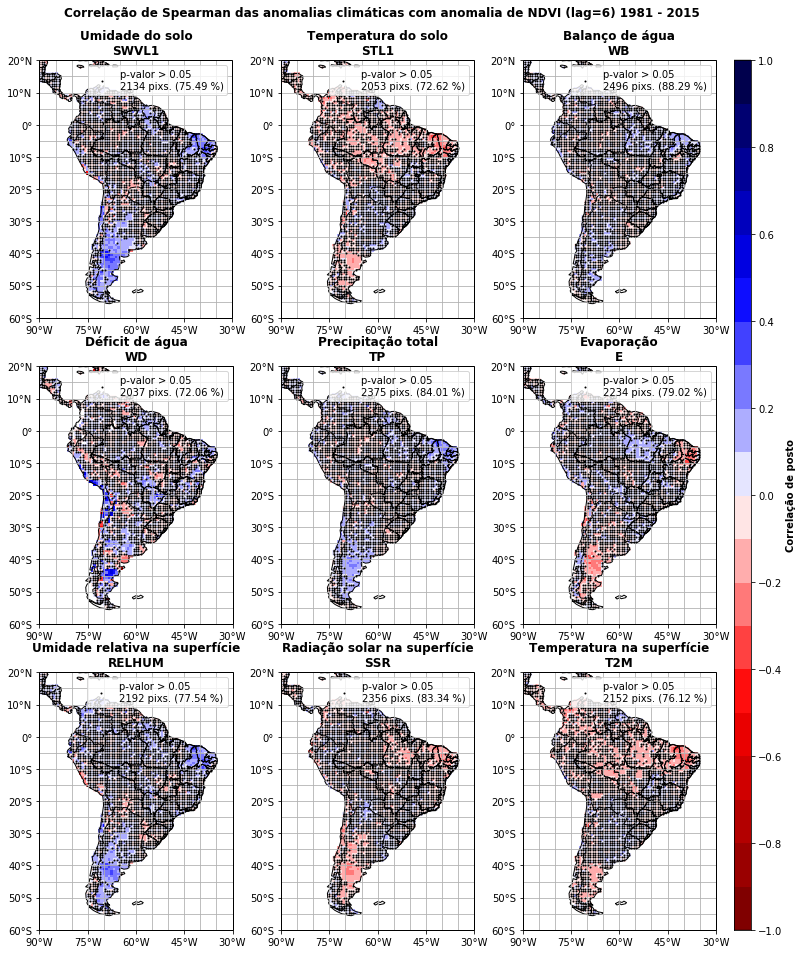

In [18]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 15))

axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 3),
    axes_pad=0.675,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = rhos[index].sel(stats="rho").where(rhos[index].land_mask == True).plot(
        ax=axis,
        vmin=-1.0,
        vmax=1.0,
        levels=np.arange(-1.0, 1.1, 0.1),
        cmap=plt.cm.seismic_r,
        add_colorbar=False,
        add_labels=False
    )

    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )    

    # Statistical significant trends.
    mask = rhos[index].sel(stats="p_value").where(rhos[index].land_mask == True) > 0.05
    LON, LAT = np.meshgrid(mask.longitude.values, mask.latitude.values)

    # Insignificant linear relations.
    only_land = (~mask.where(mask.land_mask==True).isnull()).sum().values
    axis.plot(LON[mask], LAT[mask], ".k", markersize=2, 
              label="p-valor > 0.05\n" + str(mask.sum().values) + " pixs. " + \
                    str("(%.2f %%)" %(mask.sum().values / only_land * 100)), 
              transform=projection)
    # Legend.    
    axis.legend(loc=1)     
        
# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Correlação de posto", weight="bold")
cb.cbar_axis.set_ticks(np.arange(-1.0, 1.2, 0.2))        
plt.suptitle("Correlação de Spearman das anomalias climáticas com anomalia de NDVI (lag=6)" + \
             " 1981 - 2015", weight="bold")
plt.subplots_adjust(top=0.93)    
  

# Save figures.
plt.savefig(fig_path + "ndvi_climate_spearman_lag6_ano_pt.jpg", dpi=200, bbox_inches="tight")

## 4 Local analysis for Manaus

### 4.1 Time series

In [19]:
%%time

# Make dictionary for retrieving data. 
var_dict = {}
for var_label in var_labels:
    var_dict[var_label] = "ano"

# Manaus location.
location = "Manaus"
pix_lat = -3
pix_lon = -60

# Make pandas DataFrame object for local data.
df_local = cd.extract_monthly_means_time_series(
    var_dict=var_dict,
    pix_lat=pix_lat,
    pix_lon=pix_lon
)

# Show it.
df_local.head()

CPU times: user 7.42 s, sys: 2.7 s, total: 10.1 s
Wall time: 38.5 s


,NDVI_ano,SWVL1_ano,STL1_ano,WB_ano,WD_ano,TP_ano,E_ano,RELHUM_ano,SSR_ano,T2M_ano
1981-07-01,-0.006727,-0.016821,-0.611427,-0.001742,-0.000470,-0.001816,0.000074,-1.718101,607010.6875,-0.354816
1981-08-01,-0.002018,-0.024180,-0.389313,-0.000956,-0.001157,-0.001297,0.000341,-0.676509,-55005.3750,-0.394943
1981-09-01,0.012115,-0.020205,-0.640173,-0.000580,-0.001554,-0.000870,0.000290,-0.115033,-52771.0000,-0.748481
1981-10-01,0.016583,-0.019549,-0.104223,-0.001104,-0.002198,-0.001214,0.000110,-1.321410,809763.0000,0.094039
1981-11-01,-0.075322,-0.022382,0.078872,-0.000399,-0.001249,-0.000460,0.000062,-0.720892,552124.3750,0.149060


CPU times: user 3.51 s, sys: 67.9 ms, total: 3.58 s
Wall time: 3.58 s


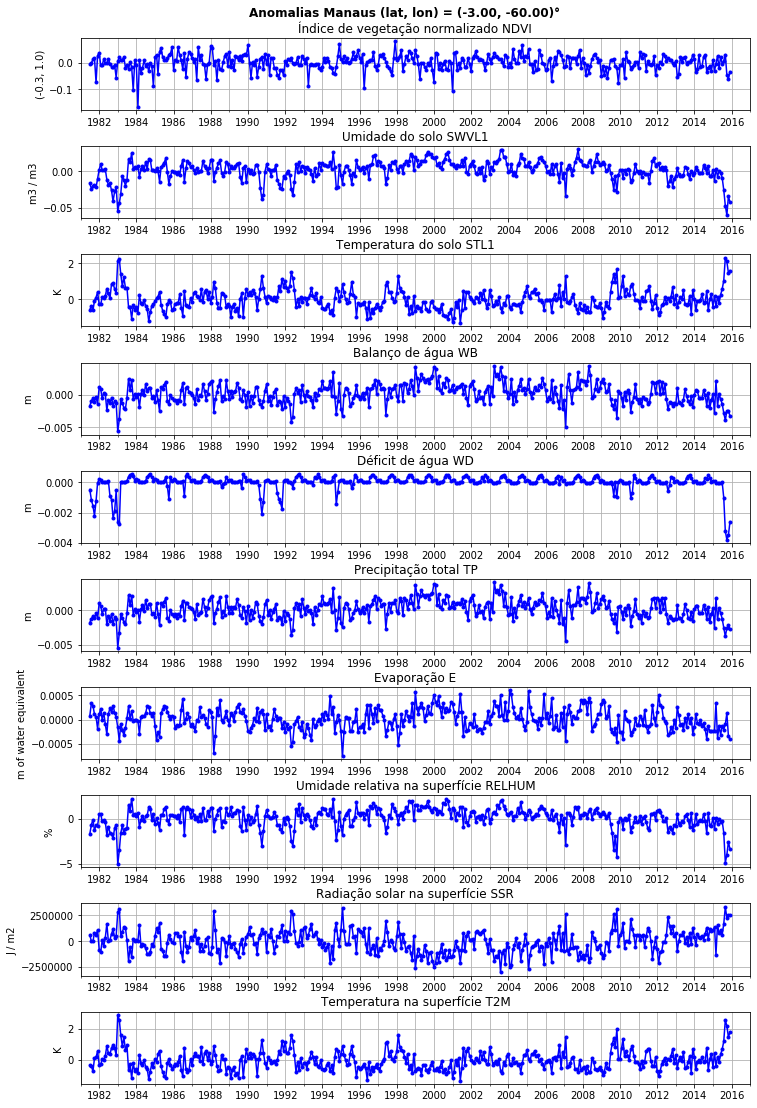

In [20]:
%%time

# Make dictionary for retrieving data. 
var_dict2 = {}
for var_label, var_code in zip(var_labels, codes):
    var_dict2[var_label] = var_code

# Plot all time series.
cols = df_local.columns
fig, axes = plt.subplots(ncols=1, nrows=cols.size, figsize=(12, cols.size * 1.75))
years = mdates.YearLocator(2)
years_fmt = mdates.DateFormatter("%Y")

for index, var_label in enumerate(var_dict2.keys()):
    code = var_dict2[var_label]
    axes[index].plot(df_local.index, df_local.loc[:, var_label], ".-b")
    axes[index].set_title(dict_titles_pt[code])
    axes[index].set_xlim(pd.Timestamp("1981"), pd.Timestamp("2017"))
    axes[index].set_xticks(pd.date_range(start="1981", end="2017", freq="1YS"), minor=True)    
    axes[index].xaxis.set_major_locator(years)
    axes[index].xaxis.set_major_formatter(years_fmt) 
    axes[index].grid(which="both")
    axes[index].set_ylabel(dict_units[code])

# Further adjustments.
plt.suptitle("Anomalias Manaus (lat, lon) = (%.2f, %.2f)°" %(pix_lat, pix_lon), weight="bold")
plt.subplots_adjust(top=0.955, hspace=0.5)

# Save figures.
plt.savefig(fig_path + "time_series_manaus_ano_pt.jpg", dpi=200, bbox_inches="tight")

### 4.2 Autocorrelations

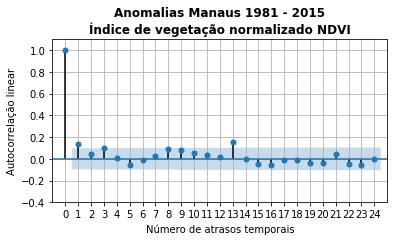

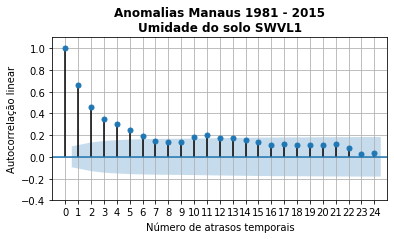

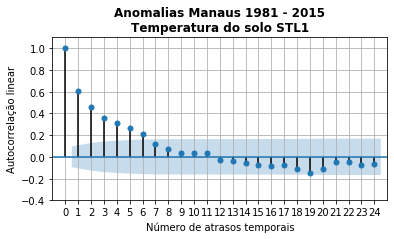

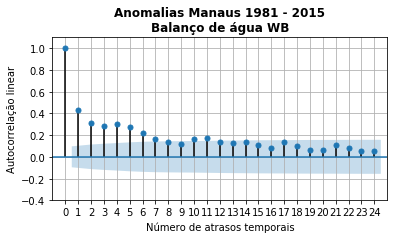

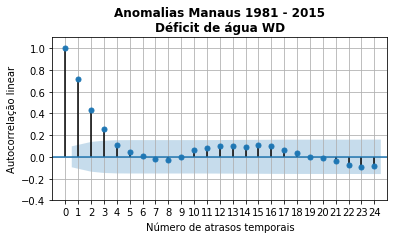

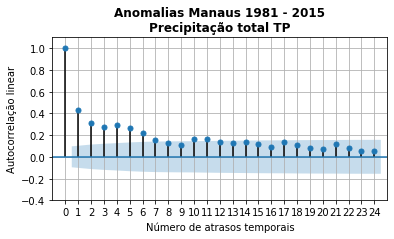

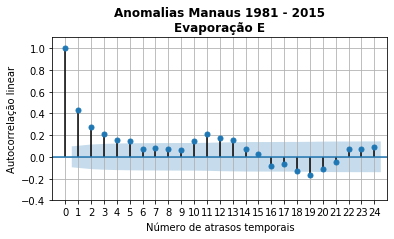

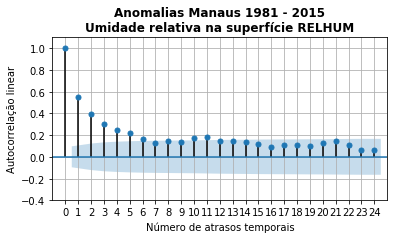

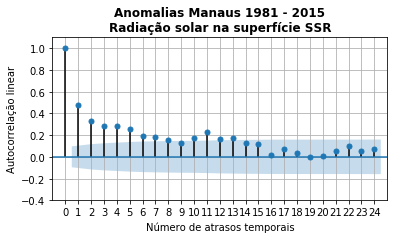

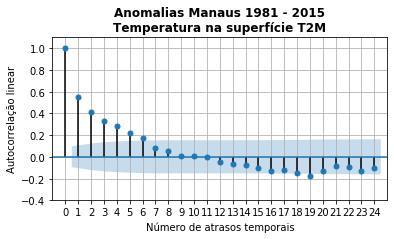

In [21]:
# Auto correlation plots.
for var_label, var_code in var_dict2.items():

    cdlearn.plotting.autocorrelation(
        data_frame=df_local,
        var_label=var_label,
        lags=24,
        figsize=(6, 3),
        ylim=(-0.4, 1.1),
        xlabel="Número de atrasos temporais",
        ylabel="Autocorrelação linear",
        title="Anomalias Manaus 1981 - 2015\n" + dict_titles_pt[var_code]
    )
    
    # Save figures.
    plt.savefig(
        fig_path + "autocorrelation_" + var_dict2[var_label] + "_" + location.lower() + \
        "_ano_pt.jpg", dpi=200, bbox_inches="tight"
    )

### 4.3 Pair plots

CPU times: user 7.71 s, sys: 76.2 ms, total: 7.79 s
Wall time: 7.79 s


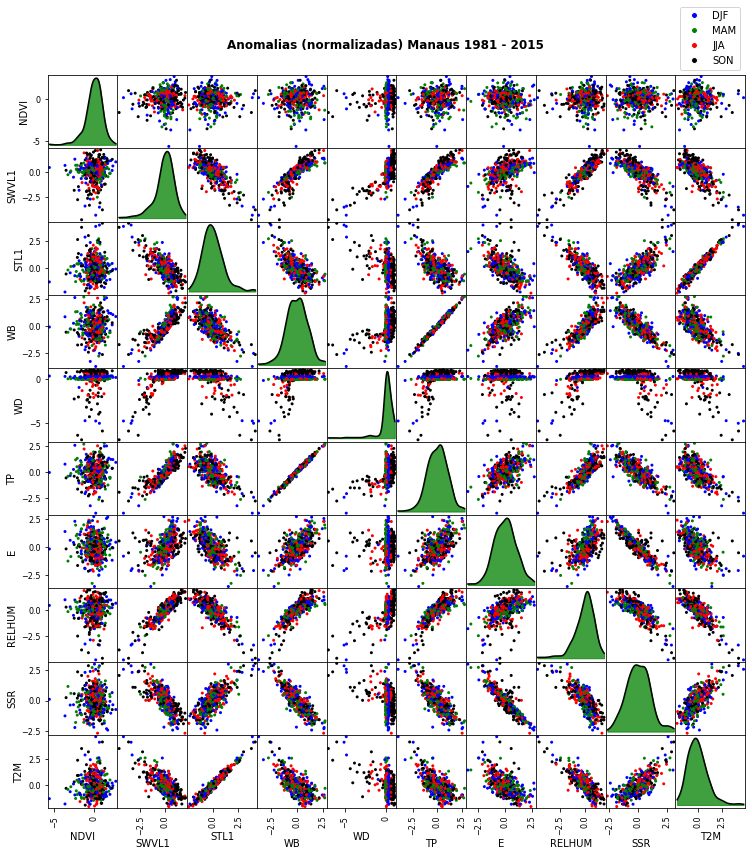

In [22]:
%%time

axes= cdlearn.plotting.pair_plot_mm(
    data_frame=df_local,
    standard_scaler=True,
    colorful=True,
    suptitle="Anomalias (normalizadas) Manaus 1981 - 2015"
)

# Save figures.
plt.savefig(fig_path + "pair_plots_manaus_ano_pt.jpg", dpi=200, bbox_inches="tight")